# Iteration 1 - YOLOv8m Table Detector Model

> **Dataset**: Marmot Dataset <br/>
> **Model**: YOLOv8m Table Detector<br/>
> **Creator**: Ryo

### Install Additional Packages

- **tesseract-ocr**: `tesseract-ocr` is an open-source Optical Character Recognition (OCR) engine developed by Google. Installing it via `!sudo apt install tesseract-ocr` allows the system to use Tesseract to convert images of text into machine-readable text. It is commonly used in tasks such as document digitization, table recognition, and image-to-text conversion.

- **pytesseract**: `pytesseract` is a Python binding for Tesseract-OCR. By installing `pytesseract`, you can integrate Tesseract OCR functionality directly into your Python scripts. This library simplifies the process of running Tesseract OCR in Python to extract text from images.

- **transformers**: `transformers` is a Python library developed by Hugging Face, designed for state-of-the-art Natural Language Processing (NLP) tasks using Transformer models like BERT, GPT, and T5. Installing this allows you to leverage pre-trained models and architectures to handle a variety of language understanding tasks such as text classification, text generation, and translation.

- **ultralyticsplus==0.0.23**: `ultralyticsplus` is a Python package built on top of the `ultralytics` library, providing additional features and models for object detection and segmentation, including support for YOLO models. By installing version `0.0.23`, you can access functionalities like model loading, fine-tuning, and inference for computer vision tasks.

- **ultralytics==8.0.21**: `ultralytics` is a package developed by Ultralytics for training, deploying, and running YOLO (You Only Look Once) object detection models. This library provides a straightforward interface for working with YOLOv5 and YOLOv8 models in Python. Installing version `8.0.21` allows you to access object detection models for detecting objects, tables, and bounding boxes within images.

In [1]:
# %pip install paddlepaddle

In [2]:
# %pip install paddleocr --user

In [3]:
# %pip install -q pytesseract transformers ultralyticsplus ultralytics timm

In [4]:
# %pip install -q git+https://github.com/huggingface/transformers.git

### Import Libraries

In [5]:
# Essential libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.express as px
import plotly.graph_objects as go

# OCR and image processing libraries
import pytesseract
from pytesseract import Output
import cv2
from PIL import Image, ImageEnhance, ImageFilter

# YOLO object detection and rendering
from ultralyticsplus import YOLO, render_result
from transformers import DetrFeatureExtractor, TableTransformerForObjectDetection

# PyTorch
import torch

# Text matching and comparison
import difflib
import re
from pathlib import Path

#### *Settings*

In [6]:
# Specify the Tesseract command location for Windows
pytesseract.pytesseract.tesseract_cmd = r'D:\Software\Tesseract-OCR\tesseract.exe'

# Display options for pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Global Variables

In [7]:
# Path to the folder containing images
base_folder = '../data'
image_folder = os.path.join(base_folder, 'improved')

## **Data Collection**

### Load Random Image

#### *Function*

In [8]:
def load_random_image_from_folder(image_folder):
    """
    Load one random image from the specified folder.

    Parameters:
        image_folder (str): The path to the folder containing images.

    Returns:
        numpy.ndarray: The randomly selected image as a NumPy array, or None if no image is found.
    """
    # Step 1: Convert the image folder path to a Path object for easier handling
    image_folder = Path(image_folder)

    # Step 2: Check if the folder exists and is indeed a directory
    if not image_folder.is_dir():
        print(f"Error: The folder '{image_folder}' does not exist or is not a directory.")
        return None

    # Step 3: Define the allowed image file extensions (case-insensitive)
    image_extensions = {'.jpg', '.jpeg', '.png'}

    # Step 4: Collect all image files in the folder with the allowed extensions
    image_files = [
        file for file in image_folder.iterdir()
        if file.suffix.lower() in image_extensions
    ]

    # Step 5: Check if any image files were found
    if not image_files:
        print("Error: No image files found in the folder.")
        return None

    # Step 6: Randomly select one image from the list of image files
    random_image = random.choice(image_files)

    # Step 7: Open the image and ensure it is in RGB format
    img = Image.open(random_image).convert("RGB")

    # Step 8: Convert the image to a NumPy array for compatibility with other libraries
    img_array = np.array(img)

    # Step 9: Return the image array
    return img_array

#### *Implementation*

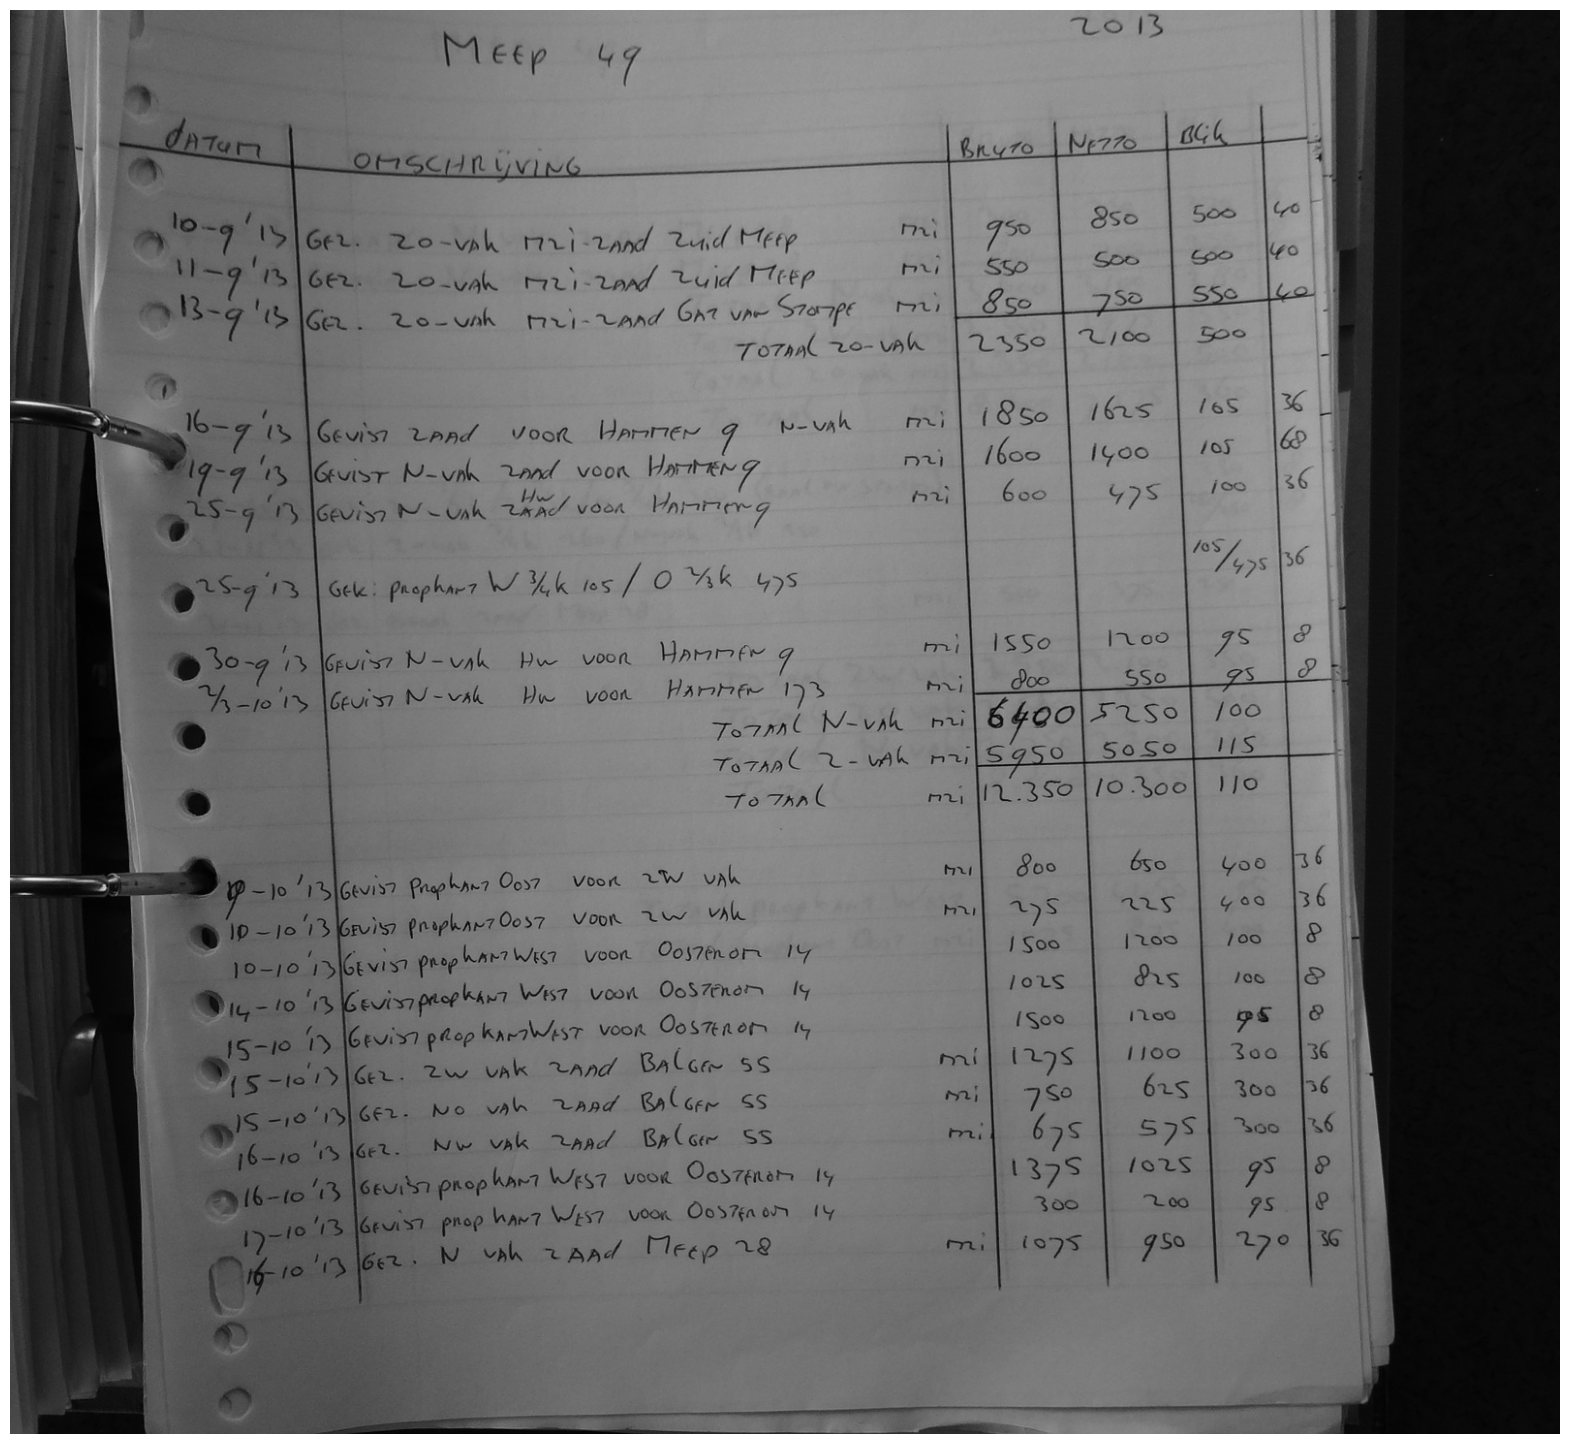

In [9]:
# Load one random image from the folder
img = load_random_image_from_folder(image_folder)

# If an image was successfully loaded, display it
if img is not None:
    plt.figure(figsize=(20, 20))
    plt.imshow(img)
    plt.axis('off')  # Hide the axes for a cleaner look
    plt.show()
else:
    print("No image to display.")

## **Modeling 1 - YOLOv8m Table Detection**

### YOLOv8m Model

#### *Explanation*

YOLOv8m (You Only Look Once, version 8 medium) is a model specifically designed for object detection tasks, including table detection. Here's a simplified explanation:

- **YOLOv8m Overview**: YOLOv8m is part of the YOLO family of models, which are popular for real-time object detection because of their speed and accuracy. The "m" in YOLOv8m stands for "medium," indicating it's a balance between model size and performance compared to larger (YOLOv8l) or smaller (YOLOv8s) models.

- **Table Detection with YOLOv8m**: When used for detecting tables, YOLOv8m can quickly scan an image and predict the location of tables by drawing bounding boxes around them. This is useful in tasks like document analysis, where you want to automatically detect and extract tables from images or scanned documents.

- **How It Works**:
  1. **Input**: You provide an image (e.g., a scanned document or a photo containing tables).
  2. **Detection**: YOLOv8m identifies and draws bounding boxes around any tables present in the image.
  3. **Output**: The model returns the coordinates of the detected tables, which can then be used for further processing, such as extracting table data using OCR.

- **Use Case**: YOLOv8m is used in applications where you need to detect multiple tables in documents or images quickly, making it ideal for scenarios like automated data extraction from PDFs, invoices, or reports.

#### *Initialize Model*

In [10]:
# Load the YOLO model for table extraction
model_yolo = YOLO('keremberke/yolov8m-table-extraction')

# Set model parameters
model_yolo.overrides['conf'] = 0.05   # Lower confidence threshold
model_yolo.overrides['iou'] = 0.35    # Lower IoU threshold
model_yolo.overrides['max_det'] = 3000  # Increase max detections
model_yolo.overrides['agnostic_nms'] = True  # Class-agnostic NMS

d:\Software\Python\Lib\site-packages\ultralytics\nn\tasks.py:634: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location="cpu"), file  # load


#### *Parameter Explanations*

- **`conf`: NMS confidence threshold**
  - **Description**: Sets the minimum confidence score required for a detection to be considered valid. Predictions with confidence below this threshold will be discarded.
  - **Example**: `0.25` means detections must have at least 25% confidence to be kept.

- **`iou`: NMS IoU threshold**
  - **Description**: Defines the Intersection over Union (IoU) threshold used in Non-Maximum Suppression (NMS). It controls how much overlap between detected objects is allowed before they are considered duplicates and one is suppressed.
  - **Example**: `0.45` allows up to 45% overlap between boxes before suppressing.

- **`agnostic_nms`: NMS class-agnostic**
  - **Description**: If set to `True`, Non-Maximum Suppression (NMS) will ignore class labels when suppressing overlapping boxes, treating all classes the same. If `False`, it will suppress only overlapping boxes of the same class.
  - **Example**: `False` means that class labels will be considered in the NMS process.

- **`max_det`: Maximum number of detections per image**
  - **Description**: Specifies the maximum number of detections the model can return for a single image. This prevents the model from returning an excessive number of detections.
  - **Example**: `1000` allows up to 1000 detections to be returned per image.

### Crop Image

#### *Function*

In [11]:
def crop_image(image, left_padding=10, right_padding=15, top_padding=10, bottom_padding=10):
    """
    Crop the image with specified padding values, focusing on cutting out the left side and applying the padding.

    Parameters:
        image (numpy.ndarray): The input image to be cropped.
        left_padding (int): The amount of padding to add to the left side of the image.
        right_padding (int): The amount of padding to add to the right side of the image.
        top_padding (int): The amount of padding to add to the top side of the image.
        bottom_padding (int): The amount of padding to add to the bottom side of the image.

    Returns:
        numpy.ndarray: Cropped image with applied padding.
    """
    # Get the image dimensions (height and width)
    height, width = image.shape[:2]

    # Calculate new coordinates with padding
    x1 = max(0, left_padding)           # Apply left padding
    y1 = max(0, top_padding)            # Apply top padding
    x2 = min(width, width - right_padding)  # Apply right padding
    y2 = min(height, height - bottom_padding) # Apply bottom padding

    # Crop the image using the adjusted coordinates
    cropped_image = image[y1:y2, x1:x2]

    # Return the cropped image
    return cropped_image

#### *Implementation*

Cropping the image with custom padding...
Cropping of the image completed.


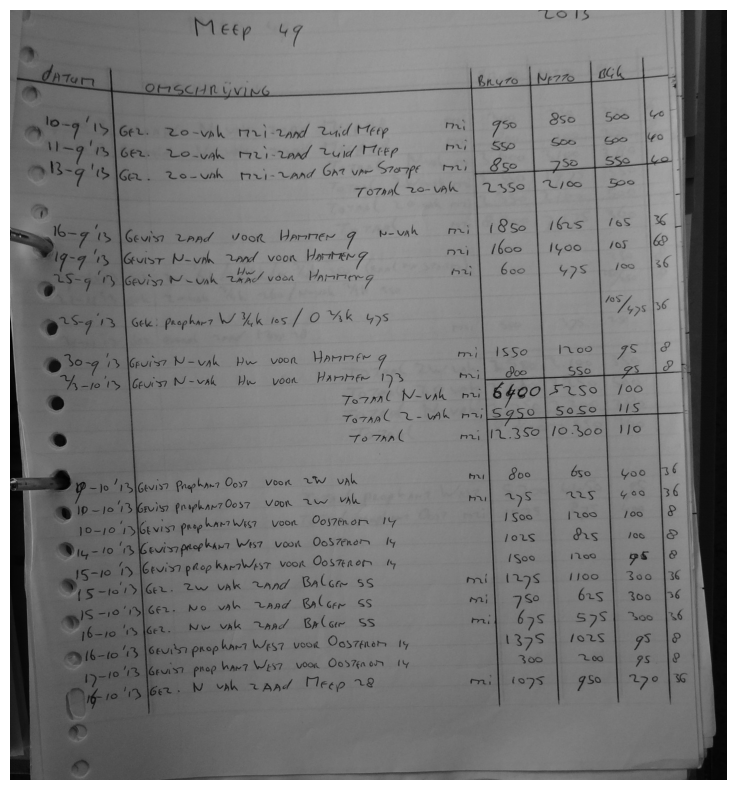

In [33]:
# Load and crop the image before inference
print("Cropping the image with custom padding...")

# Define custom padding values
left_padding = 100   # Large padding on the left to crop out the left side
right_padding = 150    # Standard padding on the right
top_padding = 10      # Standard padding on the top
bottom_padding = 10   # Standard padding on the bottom

# Perform cropping of the image using the custom padding
cropped_image = crop_image(
    image=img,
    left_padding=left_padding,
    right_padding=right_padding,
    top_padding=top_padding,
    bottom_padding=bottom_padding
)

# Optional: Print a message indicating cropping is completed
print("Cropping of the image completed.")

# Visualize the cropped image
plt.figure(figsize=(10, 10))  # Set the figure size for better visibility
plt.imshow(cropped_image)     # Display the cropped image
plt.axis('off')               # Hide axes for a cleaner look
plt.show()                    # Render and show the cropped image

### Predict Table Position

#### *Implementation*

In [34]:
# List to store cropped tables
cropped_tables = []

# Perform inference on the cropped image
print("Performing inference on the cropped image...")

# Run YOLO inference on the cropped image
results = model_yolo.predict(cropped_image)

# Add a divider before printing detection results
print("=" * 50)  # Divider

# Check and print the number of detected tables
num_tables = len(results[0].boxes)
if num_tables > 0:
    print(f"Detected {num_tables} table(s) in the image.")
    
    # Iterate over each detected table box
    for idx, box in enumerate(results[0].boxes, start=1):
        # Extract bounding box coordinates
        x1, y1, x2, y2 = box.xyxy[0].cpu().int().tolist()

        # Crop the table from the original image using the bounding box
        cropped_table = cropped_image[y1:y2, x1:x2]
        
        # Append the cropped table to the list
        cropped_tables.append(cropped_table)

else:
    print("No tables detected in the image.")

# Add a divider after printing detection results
print("=" * 50)  # Divider

Performing inference on the cropped image...

0: 640x608 1 bordered, 1090.7ms
Speed: 7.9ms preprocess, 1090.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)
Detected 1 table(s) in the image.


### Visualize Prediction Result

#### *Function*

In [35]:
# Visualize the detection results on the image (bounding boxes from YOLO)
def visualize_inference(image, results):
    """
    Visualize the YOLO inference result by drawing bounding boxes on the image.

    Parameters:
        image (numpy.ndarray): The input image to draw bounding boxes on.
        results: The YOLO results containing detected boxes.
    """
    # Create a copy of the image to draw bounding boxes
    visualized_image = image.copy()

    # Iterate through all detected boxes
    for idx, box in enumerate(results[0].boxes, start=1):
        # Extract bounding box coordinates
        x1, y1, x2, y2 = box.xyxy[0].cpu().int().tolist()

        # Draw bounding box on the image
        visualized_image = cv2.rectangle(visualized_image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue box

        # Add label for each bounding box
        score = box.conf.cpu().item()  # Confidence score
        cv2.putText(visualized_image, f'Table {idx}: {score:.2f}', (x1, y1 - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)  # Blue text

    return visualized_image

#### *Implementation*

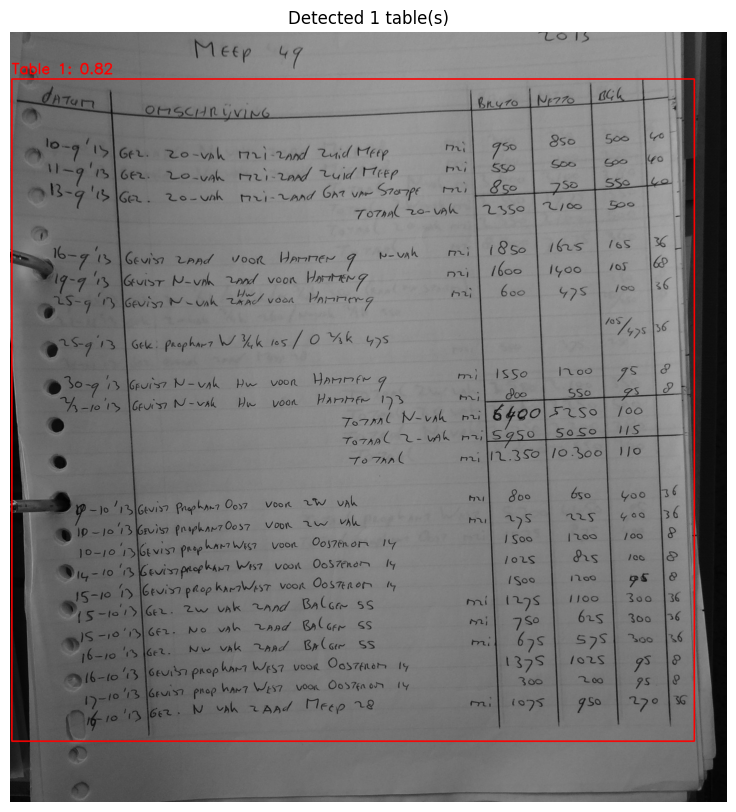

In [36]:
# Get the image with bounding boxes visualized
rendered_image_with_boxes = visualize_inference(cropped_image, results)

# Display the result with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(rendered_image_with_boxes)
plt.axis('off')  # Hide axes for a cleaner look
plt.title(f'Detected {num_tables} table(s)')
plt.show()

### Display Predicted Cropped Table

#### *Function*

In [37]:
def display_cropped_table_by_index(index):
    """
    Display a cropped table image from the list of cropped tables using its index.

    Parameters:
        index (int): The index of the cropped table to display.
    """
    # Step 1: Check if the index is within the valid range of cropped tables
    if not 0 <= index < len(cropped_tables):
        print(f"Error: Index {index} is out of bounds. Available range: 0 to {len(cropped_tables) - 1}.")
        return

    # Step 2: Retrieve the cropped table image by index
    cropped_table = cropped_tables[index]

    # Step 3: Display the cropped table image using matplotlib
    plt.figure(figsize=(20, 20))
    plt.imshow(cropped_table)
    plt.title(f"Displaying Cropped Table {index}")
    plt.axis('off')  # Hide axes for a cleaner presentation
    plt.show()

#### *Implementation*

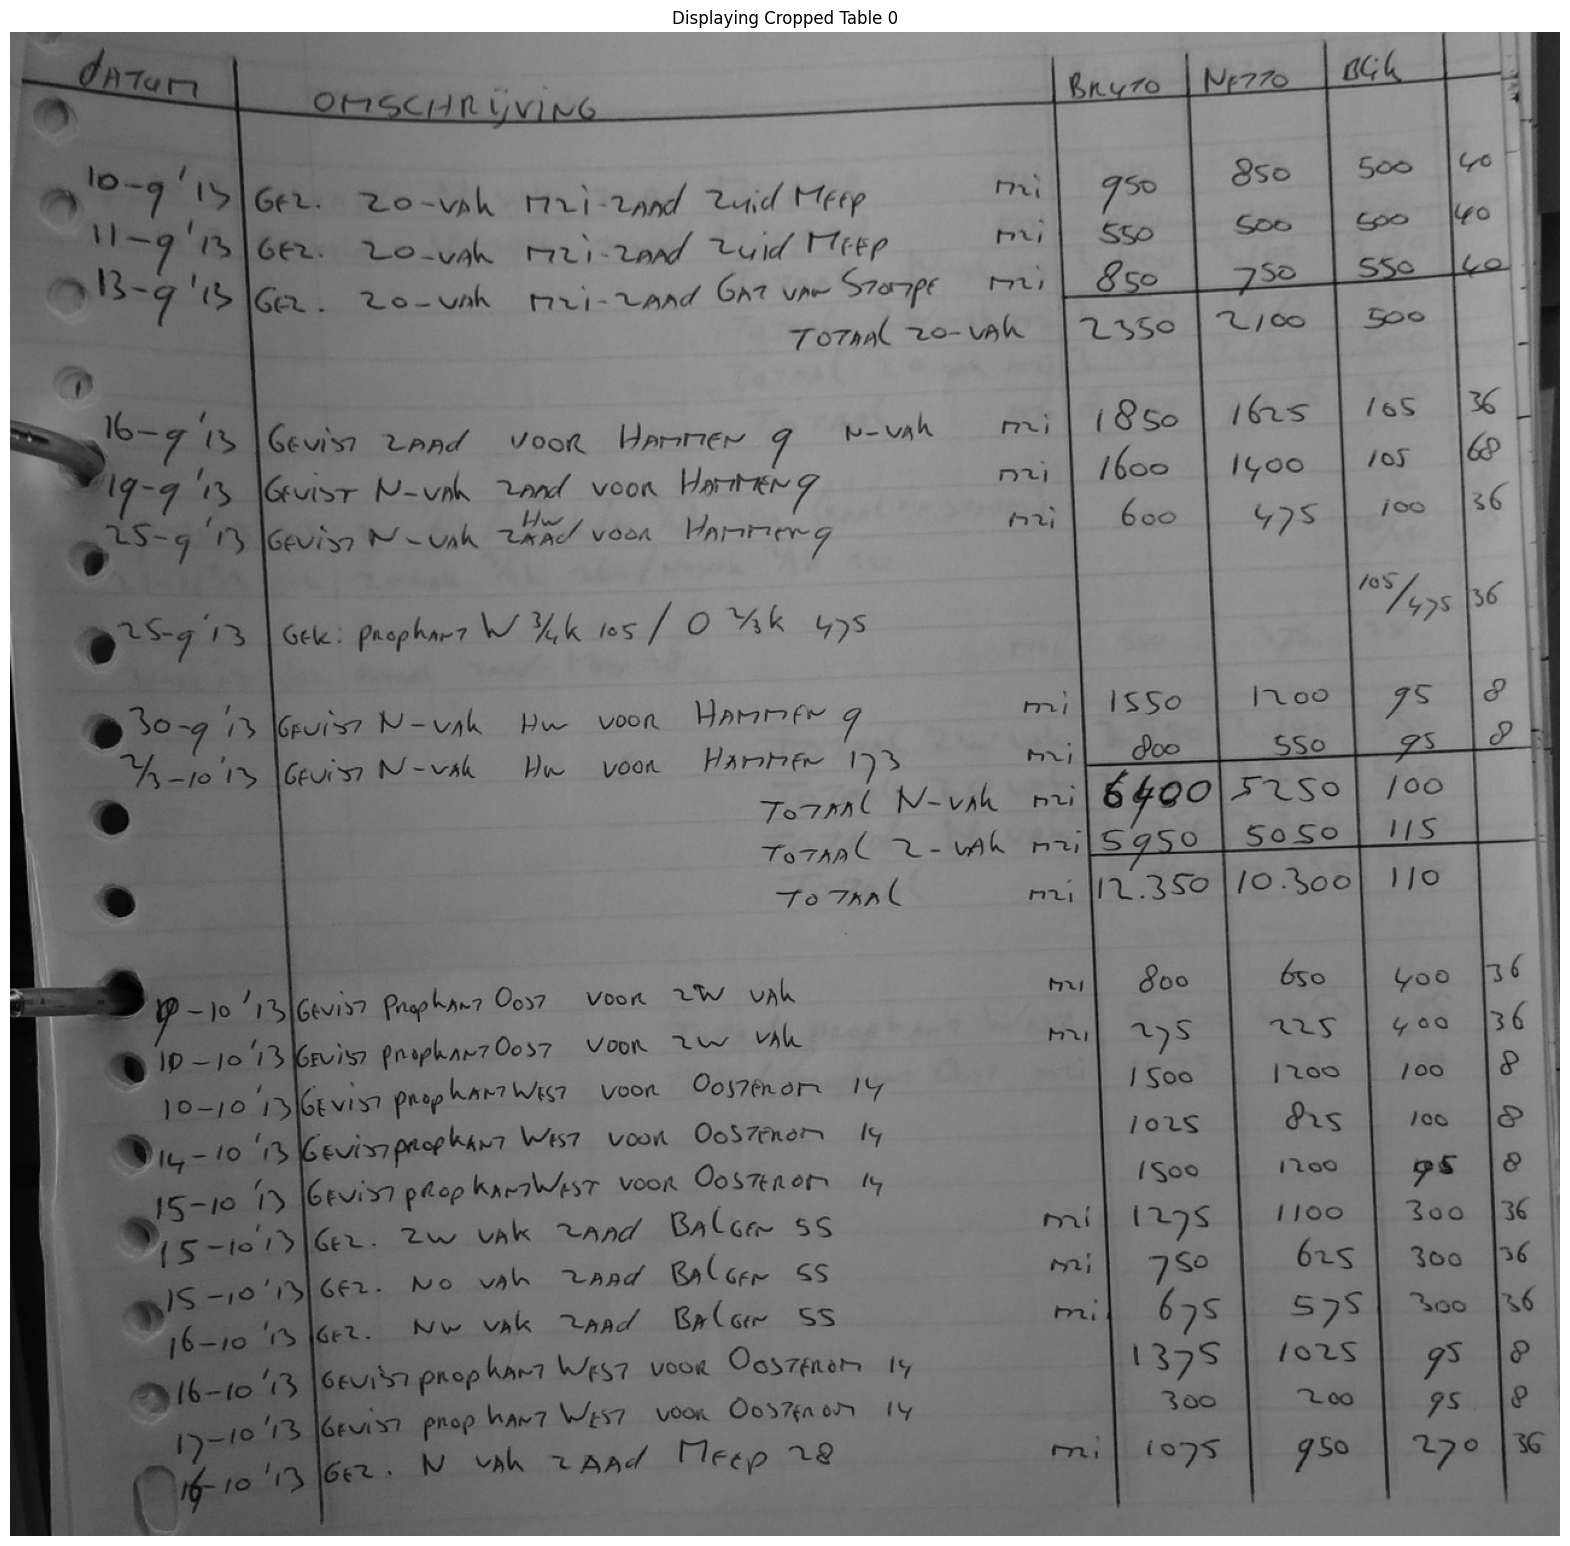

In [38]:
display_cropped_table_by_index(0)

## **Data Post-Processing 1 - Cropped Tables**

### Enhance Cropped Image Quality

#### *Function*

In [39]:
def enhance_cropped_image_quality(image_np):
    """
    Enhance the quality of the image by improving sharpness, contrast, and brightness.

    Parameters:
        image_np (numpy.ndarray): The cropped table image in NumPy array format.

    Returns:
        PIL.Image.Image: The enhanced image.
    """
    # Step 1: Convert the NumPy array to a PIL Image
    image = Image.fromarray(image_np)

    # Step 2: Apply initial sharpening to enhance edges and text
    enhanced_image = image.filter(ImageFilter.SHARPEN)

    # Step 3: Enhance the contrast for better clarity
    contrast_enhancer = ImageEnhance.Contrast(enhanced_image)
    enhanced_image = contrast_enhancer.enhance(1.2)  # Increase contrast by a factor of 1.2

    # Step 4: Enhance the sharpness to make text more visible
    sharpness_enhancer = ImageEnhance.Sharpness(enhanced_image)
    enhanced_image = sharpness_enhancer.enhance(1.5)  # Increase sharpness by a factor of 1.5

    # Step 5: Adjust the brightness if needed
    brightness_enhancer = ImageEnhance.Brightness(enhanced_image)
    enhanced_image = brightness_enhancer.enhance(0.9)  # Slightly increase brightness

    # Step 6: Return the enhanced image
    return enhanced_image

#### *Implementation*

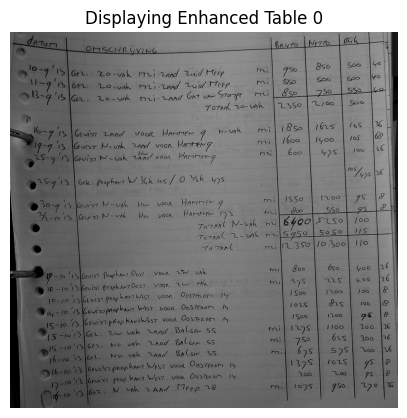

Enhanced images have been updated. Total enhanced tables: 1


In [40]:
# Initialize a list to store the enhanced images
enhanced_tables = []

# Iterate over each cropped table image
for idx, cropped_table in enumerate(cropped_tables):
    # Step 1: Enhance the image quality
    enhanced_image = enhance_cropped_image_quality(cropped_table)
    
    # Step 2: Convert the enhanced image back to a NumPy array and store it
    enhanced_tables.append(np.array(enhanced_image))
    
    # Step 3: Display the enhanced image for verification
    plt.figure(figsize=(5, 5))
    plt.imshow(enhanced_image)
    plt.title(f"Displaying Enhanced Table {idx}")
    plt.axis('off')  # Hide axes for a cleaner look
    plt.show()

# Add a divider for clarity
print("=" * 50)

# Verify that images have been enhanced
print(f"Enhanced images have been updated. Total enhanced tables: {len(enhanced_tables)}")

# Add another divider
print("=" * 50)

## **Modeling 2 - Microsoft Table Transformer**

#### *Defined Colors* 

In [22]:
# Define colors for visualization
COLORS = [
    [0.000, 0.447, 0.741],  # Blue
    [0.850, 0.325, 0.098],  # Orange
    [0.929, 0.694, 0.125],  # Yellow
    [0.494, 0.184, 0.556],  # Purple
    [0.466, 0.674, 0.188],  # Green
    [0.301, 0.745, 0.933],  # Light Blue
]

#### *Function*

In [23]:
def plot_results(pil_img, scores, labels, boxes):
    """
    Plot detection results using Plotly per label category, excluding 'table'.

    Parameters:
        pil_img (PIL.Image.Image): The image on which to plot results.
        scores (torch.Tensor): The detection scores.
        labels (torch.Tensor): The detected labels.
        boxes (torch.Tensor): The bounding boxes for the detected objects.
    """
    # Convert PIL Image to NumPy array
    img_np = np.array(pil_img)

    # Step 1: Create a dictionary to store detections per category, excluding 'table'
    categories = {
        label_name: []
        for _, label_name in label_dict.items()
        if label_name != 'table'
    }

    # Step 2: Organize detections into their respective categories
    for score, label, box in zip(scores.tolist(), labels.tolist(), boxes.tolist()):
        label_name = label_dict.get(label, 'unknown')
        if label_name in categories:
            categories[label_name].append((score, box))

    # Step 3: Filter out categories with no detections
    categories = {cat: dets for cat, dets in categories.items() if dets}

    # Step 4: Check if there are any detections to display
    if not categories:
        print("No detections to display.")
        return

    # Step 5: Initialize the figure with the image
    fig = px.imshow(img_np)

    # Step 6: Add shapes (bounding boxes) for each category with a single color per category
    for idx, (category, detections) in enumerate(categories.items()):
        color = COLORS[idx % len(COLORS)]  # Assign a unique color per category
        x_coords, y_coords = [], []  # Store all x and y coordinates for the same category

        for (score, (xmin, ymin, xmax, ymax)) in detections:
            # Append coordinates for the bounding box
            x_coords += [xmin, xmax, xmax, xmin, xmin, None]  # None is used to break the line between boxes
            y_coords += [ymin, ymin, ymax, ymax, ymin, None]

        # Add a single trace per category with all bounding boxes
        fig.add_trace(go.Scatter(
            x=x_coords,
            y=y_coords,
            mode='lines',
            line=dict(color=f"rgb({color[0]*255},{color[1]*255},{color[2]*255})", width=3),
            name=f'{category}',  # Single label for each category in the legend
            showlegend=True  # Show legend for each label
        ))

    # Step 7: Update layout for legend interaction
    fig.update_layout(
        title="Detected Objects with Interactive Labels",
        xaxis_showgrid=False,
        yaxis_showgrid=False,
        height=img_np.shape[0],
        width=img_np.shape[1],
        legend_title="Detected Categories"
    )

    # Show the interactive plot with legend functionality
    fig.show()

#### *Function*

In [26]:
def deskew_image(image, angle=-1):
    """
    Deskew (straighten) an image by rotating it by a given angle.
    
    Parameters:
        image (numpy.ndarray): Input image to be deskewed.
        angle (float): Angle in degrees to rotate the image for deskewing.
                    Default is -1 degree to correct slight rightward skew.
    
    Returns:
        numpy.ndarray: The deskewed (straightened) image.
    """
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return rotated_image

In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_lines_in_tables(enhanced_tables, min_column_distance=50, left_margin=10, min_row_distance=20, angle_tolerance=10):
    """
    Detect near-vertical lines in enhanced table images and return the processed images
    with detected lines overlaid.

    Parameters:
        enhanced_tables (list): A list of enhanced table images in NumPy array format.
        min_column_distance (int): Minimum distance between columns to consider as separate columns.
        left_margin (int): Extra margin added to the left side of the first column to prevent cutting off content.
        min_row_distance (int): Minimum distance between rows (not used in this version, but kept for future use).
        angle_tolerance (float): Tolerance in degrees for near-vertical lines (90 +/- angle_tolerance).

    Returns:
        list: Processed images with detected columns.
        list: Detected near-vertical lines.
    """
    processed_images = []
    all_vertical_lines = []
    
    for idx, enhanced_image_np in enumerate(enhanced_tables):
        print(f"Processing Table {idx}...")

        try:
            # Convert the image to grayscale
            img_gray = cv2.cvtColor(enhanced_image_np, cv2.COLOR_RGB2GRAY)

            # Detect edges using Canny edge detector
            edges = cv2.Canny(img_gray, 50, 150, apertureSize=3)

            # Detect lines using Hough Line Transform
            lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=100, maxLineGap=10)

            # Convert image to BGR for visualization
            img_color = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)

            # Collect the positions of near-vertical lines
            vertical_lines = []
            if lines is not None:
                for line in lines:
                    x1, y1, x2, y2 = line[0]
                    angle = np.abs(np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi)
                    if 90 - angle_tolerance <= angle <= 90 + angle_tolerance:
                        vertical_lines.append((x1, y1, x2, y2))

            # Process and merge near-vertical lines
            if vertical_lines:
                vertical_lines.sort(key=lambda x: x[0])  # Sort lines by their x1 position
                merged_vertical_lines = [vertical_lines[0]]
                for line in vertical_lines[1:]:
                    x1_current, _, _, _ = line
                    x1_last, _, _, _ = merged_vertical_lines[-1]
                    if abs(x1_current - x1_last) > min_column_distance:
                        merged_vertical_lines.append(line)

                # Draw bounding boxes for each column
                for i in range(len(merged_vertical_lines) - 1):
                    x1_current, _, _, _ = merged_vertical_lines[i]
                    x1_next, _, _, _ = merged_vertical_lines[i + 1]

                    # Apply left margin adjustment to the first column
                    if i == 0:
                        x1_current = max(0, x1_current - left_margin)

                    # Draw a rectangle to create column bounding box
                    cv2.rectangle(img_color, (x1_current, 0), (x1_next, img_color.shape[0]), (255, 0, 0), 2)

            # Save processed image and vertical lines
            processed_images.append(img_color)
            all_vertical_lines.append(merged_vertical_lines)

            # Visualize the result
            plt.figure(figsize=(12, 12))
            plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
            plt.title(f'Detected Near-Vertical Lines for Table {idx}')
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"An error occurred while processing Table {idx}: {e}")
            
    return processed_images, all_vertical_lines

Processing Table 0...


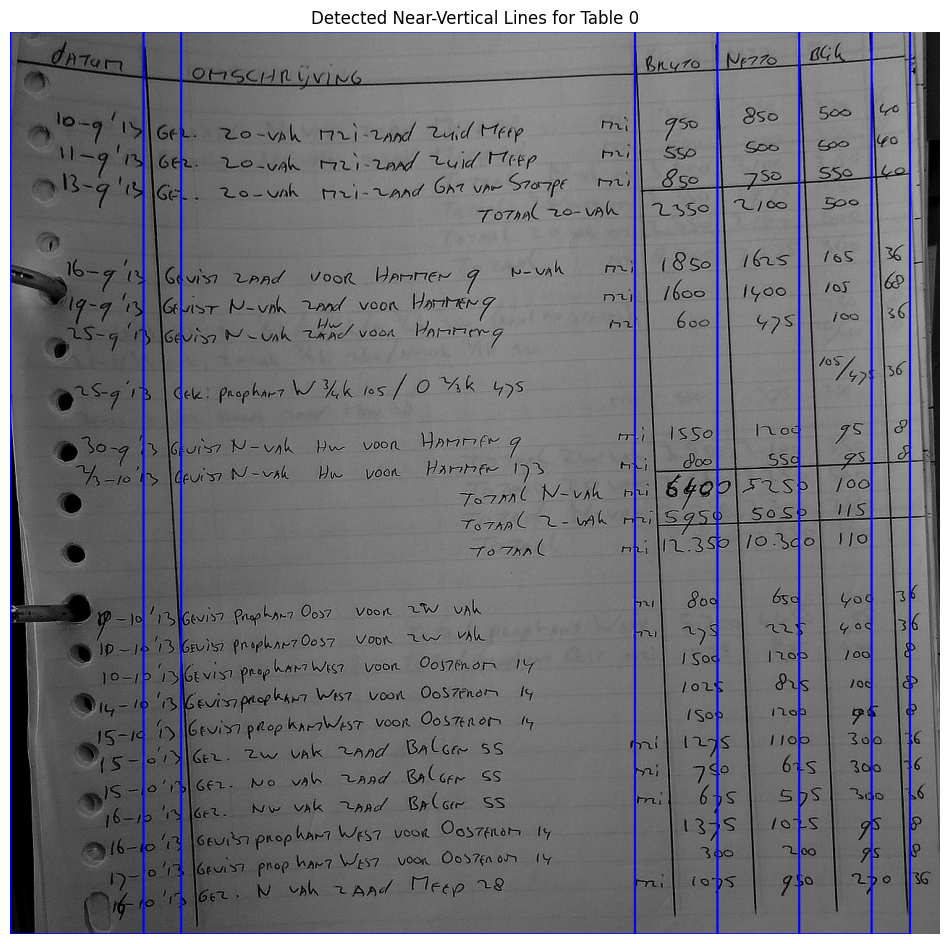

ValueError: not enough values to unpack (expected 3, got 2)

In [49]:
processed_images, all_vertical_lines, all_horizontal_lines = detect_lines_in_tables(
    enhanced_tables, 
    min_column_distance=50, 
    left_margin=25, 
    min_row_distance=25
)

In [29]:
def visualize_cropped_columns(processed_images, vertical_lines, horizontal_lines):
    """
    Visualize and return the cropped columns from each table image using subplots.

    Parameters:
        processed_images (list): A list of processed table images in NumPy array format.
        vertical_lines (list): A list of vertical lines (x-coordinates) detected in the table.
        horizontal_lines (list): A list of horizontal lines (y-coordinates) detected in the table.

    Returns:
        list: A list of lists where each sublist contains cropped column images for each table.
    """
    all_cropped_columns = []  # This will hold the cropped columns for each table

    for idx, (img_color, v_lines, h_lines) in enumerate(zip(processed_images, vertical_lines, horizontal_lines)):
        print(f"Processing and visualizing columns for Table {idx}...")

        num_cols = len(v_lines) - 1  # Number of columns
        fig, axes = plt.subplots(1, num_cols, figsize=(15, 5))

        cropped_columns = []  # To store the cropped columns for this table

        for i in range(num_cols):
            x1, x2 = v_lines[i][0], v_lines[i + 1][0]  # Get the x-coordinates of the column
            y1, y2 = h_lines[0][1], h_lines[-1][1]  # Crop from top to bottom

            # Crop the column
            cropped_col = img_color[y1:y2, x1:x2]
            cropped_columns.append(cropped_col)  # Save the cropped column

            # Display in subplot
            axes[i].imshow(cv2.cvtColor(cropped_col, cv2.COLOR_BGR2RGB))
            axes[i].set_title(f'Column {i+1}')
            axes[i].axis('off')

        plt.show()

        # Append the cropped columns to the main list for all tables
        all_cropped_columns.append(cropped_columns)

    return all_cropped_columns

Processing and visualizing columns for Table 0...


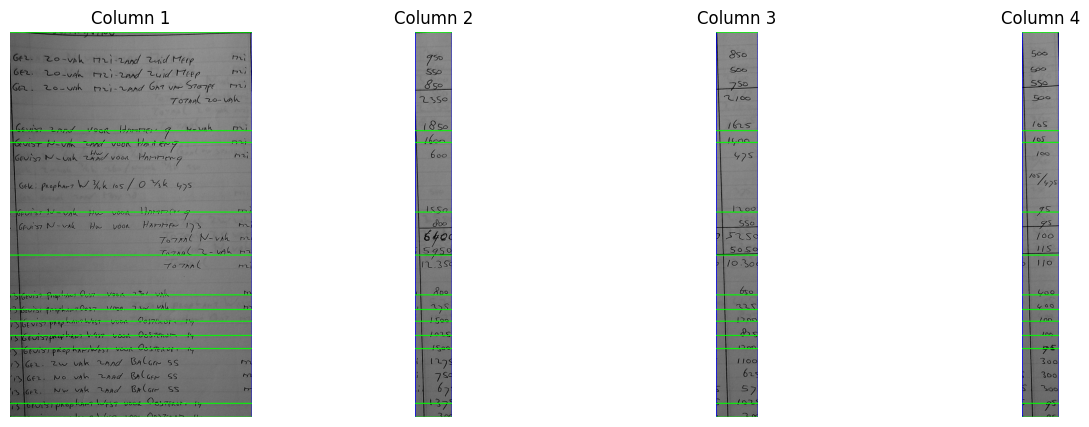

In [30]:
cropped_columns_all_tables = visualize_cropped_columns(processed_images, all_vertical_lines, all_horizontal_lines)

In [31]:
from paddleocr import PaddleOCR

# Initialize PaddleOCR model
ocr = PaddleOCR(use_angle_cls=True, lang='en')  # You can adjust the language as needed

def perform_ocr_on_visualized_columns(cropped_columns):
    """
    Perform OCR on each of the cropped columns (excluding the last column) using PaddleOCR.

    Parameters:
        cropped_columns (list): A list of cropped column images (from the visualized columns).

    Returns:
        pandas.DataFrame: A DataFrame with the OCR results for each column (excluding the last column).
    """
    column_texts = []

    # Iterate over each cropped column image (ignoring the last column)
    for idx, col_img in enumerate(cropped_columns[:5]):  # Take columns 1-5, excluding column 6
        print(f"Performing OCR on Column {idx + 1}...")

        # Convert cropped column to the format expected by PaddleOCR (from NumPy array to file or PIL Image)
        results = ocr.ocr(col_img, cls=True)  # Perform OCR using PaddleOCR
        
        # Collect recognized text for the current column
        column_text = []
        for line in results[0]:  # Extract results for each line in the column
            text = line[1][0]  # The recognized text is in line[1][0]
            column_text.append(text)

        column_texts.append(column_text)

        print(f"OCR Result for Column {idx + 1}: {column_text}")

    # Align rows for the DataFrame (based on the longest column)
    max_rows = max(len(col) for col in column_texts)
    aligned_rows = []

    for row_idx in range(max_rows):
        row = []
        for col in column_texts:
            if row_idx < len(col):
                row.append(col[row_idx])
            else:
                row.append('')  # Fill missing rows with empty strings
        aligned_rows.append(row)

    # Convert to DataFrame with column names for Columns 1-5
    column_names = ['Datum', 'Omschrijving', 'Bruto', 'Netto', 'Blik']  # Columns 1 to 5
    df = pd.DataFrame(aligned_rows, columns=column_names)

    return df

[2024/10/07 09:20:05] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\Alessandro Ryo/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\Alessandro Ryo/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 32

In [32]:
# Example usage with the list of cropped columns
cropped_columns_table_0 = cropped_columns_all_tables[0]  # Adjust this to match your actual data

# Perform OCR on the first 5 columns and get the DataFrame
ocr_result_df = perform_ocr_on_visualized_columns(cropped_columns_table_0)

# Display the DataFrame result
print(ocr_result_df)

Performing OCR on Column 1...
[2024/10/07 09:20:07] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.7142553329467773
[2024/10/07 09:20:08] ppocr DEBUG: cls num  : 21, elapsed : 0.17640924453735352
[2024/10/07 09:20:10] ppocr DEBUG: rec_res num  : 21, elapsed : 1.9258627891540527
OCR Result for Column 1: ['GFZ.Z0-vph n2i-ZAndZyidMFfp', 'mi', '6EZ.20-vAh zi-ZnAzuidHEp', 'GeZZ0-h nri-AdGnvAnS7pE', 'TOTAAZ0-A', '12i', 'GEkpnopha734k105/0/k475', 'To7N-vh n', '6EZ.ZWVAK And BAGEN55', 'FZ.NWVAKAA/BAG5S']
Performing OCR on Column 2...
[2024/10/07 09:20:10] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.27974772453308105
[2024/10/07 09:20:10] ppocr DEBUG: cls num  : 10, elapsed : 0.10424280166625977
[2024/10/07 09:20:10] ppocr DEBUG: rec_res num  : 10, elapsed : 0.48177623748779297
OCR Result for Column 2: ['950', '550', '850', '2350', '850', '600', '640', 'OSOS', '12.35']
Performing OCR on Column 3...
[2024/10/07 09:20:10] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.04851508140563965
[2024/10/07 09:2

ValueError: 5 columns passed, passed data had 4 columns

In [105]:
ocr_result_df

Datum                  Omschrijving Bruto Netto Blik
0    Li] C= 10         CEST RAM woo Malem 1~   boo  & So   se
1     ; Wis...  GEVisa7 AAA Voor imsci67 Ly)    So    LS  Seo
2    a a a “lo           GEIS7 AS Voor ep 4g    co   ELS  ySo
3   iy Te Gite      \6evi7z tprd voon Mee ag    DS   2se  boo
4     ®2-6 ‘'o   GRIST Appa Yeon T7ASten? TL    Se   Soe  ARS
5  ties 8-6 "0   IGEVIS2? LAA Yeon NK 6A7 UN   sys   2Jo  REE
6        wb co        G07 WAS voor Mayreaz 2   Yoo    os  tos
7       Ad bin        Gets? And veow Mager 2    9s    Ly  7 5
8         W545  Cevitz ped veown Masz76p7 TW    So

In [106]:
from paddleocr import PaddleOCR
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# Initialize PaddleOCR model
ocr_model = PaddleOCR(use_angle_cls=True, lang='en')

def visualize_cropped_columns(processed_images, vertical_lines, horizontal_lines):
    """
    Visualize and return the cropped columns from each table image using subplots.

    Parameters:
        processed_images (list): A list of processed table images in NumPy array format.
        vertical_lines (list): A list of vertical lines (x-coordinates) detected in the table.
        horizontal_lines (list): A list of horizontal lines (y-coordinates) detected in the table.

    Returns:
        list: A list of lists where each sublist contains cropped column images for each table.
    """
    all_cropped_columns = []  # This will hold the cropped columns for each table

    for idx, (img_color, v_lines, h_lines) in enumerate(zip(processed_images, vertical_lines, horizontal_lines)):
        print(f"Processing and visualizing columns for Table {idx}...")

        num_cols = len(v_lines) - 1  # Number of columns
        fig, axes = plt.subplots(1, num_cols, figsize=(15, 5))

        cropped_columns = []  # To store the cropped columns for this table

        for i in range(num_cols):
            x1, x2 = v_lines[i][0], v_lines[i + 1][0]  # Get the x-coordinates of the column
            y1, y2 = h_lines[0][1], h_lines[-1][1]  # Crop from top to bottom

            # Crop the column
            cropped_col = img_color[y1:y2, x1:x2]
            cropped_columns.append(cropped_col)  # Save the cropped column

            # Display in subplot
            axes[i].imshow(cv2.cvtColor(cropped_col, cv2.COLOR_BGR2RGB))
            axes[i].set_title(f'Column {i+1}')
            axes[i].axis('off')

        plt.show()

        # Append the cropped columns to the main list for all tables
        all_cropped_columns.append(cropped_columns)

    return all_cropped_columns


def perform_ocr_with_paddle(cropped_columns):
    """
    Perform OCR on each of the cropped columns using PaddleOCR (excluding the last column).

    Parameters:
        cropped_columns (list): A list of cropped column images (from the visualized columns).

    Returns:
        pandas.DataFrame: A DataFrame with the OCR results for each column (excluding the last column).
    """
    column_texts = []

    # Iterate over each cropped column image (excluding the last column)
    for idx, col_img in enumerate(cropped_columns[:-1]):  # Exclude last column (column 6)
        print(f"Performing OCR on Column {idx + 1}...")

        # Convert the cropped image to the format needed for OCR (PaddleOCR expects file paths or NumPy arrays)
        result = ocr_model.ocr(col_img, cls=True)

        # Extract the detected text from the result
        column_text = [res[1][0] for res in result[0]]  # res[1][0] contains the recognized text
        column_texts.append(column_text)

        print(f"OCR Result for Column {idx + 1}: {column_text}")

    # Align rows for the DataFrame (based on the longest column)
    max_rows = max(len(col) for col in column_texts)
    aligned_rows = []

    for row_idx in range(max_rows):
        row = []
        for col in column_texts:
            if row_idx < len(col):
                row.append(col[row_idx])
            else:
                row.append('')  # Fill missing rows with empty strings
        aligned_rows.append(row)

    # Convert to DataFrame with column names excluding the last one
    column_names = ['Datum', 'Omschrijving', 'Bruto', 'Netto']
    df = pd.DataFrame(aligned_rows, columns=column_names)

    return df


# Example call for visualizing cropped columns and performing OCR
cropped_columns_all_tables = visualize_cropped_columns(processed_images, all_vertical_lines, all_horizontal_lines)

# Perform OCR on the first table's cropped columns
ocr_result_df = perform_ocr_with_paddle(cropped_columns_all_tables[0])  # Use the first table's columns

# Display the OCR results
print(ocr_result_df)


ModuleNotFoundError: No module named 'paddleocr'